## 1. Load Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import src.picks as utils
import src.function as fc
from textblob import TextBlob
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize.treebank import TreebankWordDetokenizer
import seaborn as sns
import string
import joblib


# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

## 2. Load Configuration File 

In [2]:
config = utils.load_config()

## 3. Load Dataset

In [3]:
dataset = pd.read_csv(config["dataset_path"])

In [4]:
dataset.head()

itemId                 category             name  rating  \
0  100002528  beli-harddisk-eksternal         Kamal U.       5   
1  100002528  beli-harddisk-eksternal       yofanca m.       4   
2  100002528  beli-harddisk-eksternal  Lazada Customer       5   
3  100002528  beli-harddisk-eksternal  Lazada Customer       4   
4  100002528  beli-harddisk-eksternal         Yosep M.       5   

   originalRating                                  reviewTitle  \
0             NaN                                          NaN   
1             NaN                                          NaN   
2             NaN  ok mantaaapppp barang sesuai pesanan.. good   
3             NaN                                          NaN   
4             NaN                                          NaN   

                      reviewContent  likeCount  upVotes  downVotes  helpful  \
0   bagus  mantap dah sesui pesanan          0        0          0     True   
1                Bagus, sesuai foto          0        0          0     True   
2  okkkkk mantaaaaaaapppp ... goood          0        0          0     True   
3                      bagus sesuai          0        0          0     True   
4                               NaN          0        0          0     True   

   relevanceScore   boughtDate  clientType retrievedDate  
0           26.51  09 Apr 2019  androidApp    2019-10-02  
1           22.49  24 Sep 2017  androidApp    2019-10-02  
2           21.50  04 Apr 2018  androidApp    2019-10-02  
3           20.51  22 Sep 2017  androidApp    2019-10-02  
4           16.01  17 Agu 2018  androidApp    2019-10-02

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203787 entries, 0 to 203786
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   itemId          203787 non-null  int64  
 1   category        203787 non-null  object 
 2   name            203787 non-null  object 
 3   rating          203787 non-null  int64  
 4   originalRating  8 non-null       float64
 5   reviewTitle     23404 non-null   object 
 6   reviewContent   107029 non-null  object 
 7   likeCount       203787 non-null  int64  
 8   upVotes         203787 non-null  int64  
 9   downVotes       203787 non-null  int64  
 10  helpful         203787 non-null  bool   
 11  relevanceScore  203787 non-null  float64
 12  boughtDate      196680 non-null  object 
 13  clientType      203787 non-null  object 
 14  retrievedDate   203787 non-null  object 
dtypes: bool(1), float64(2), int64(5), object(7)
memory usage: 22.0+ MB


In [6]:
dataset = dataset[['reviewContent','rating']]

In [7]:
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      dataset.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 reviewContent    96758
rating               0
dtype: int64


In [8]:
##Remove null in review content
dataset = dataset.dropna(subset=['reviewContent'])
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      dataset.isnull().sum())
print(dataset.shape)

 
Count total NaN at each column in a DataFrame : 

 reviewContent    0
rating           0
dtype: int64
(107029, 2)


## Relabeling

In [9]:
def relabel_rating(rating, threshold):
    if rating > threshold:
        return 1
    else:
        return 0

In [10]:
dataset['sentiment'] = dataset['rating'].apply(lambda x: relabel_rating(x, 3))

In [11]:
dataset.head()

reviewContent  rating  sentiment
0   bagus  mantap dah sesui pesanan       5          1
1                Bagus, sesuai foto       4          1
2  okkkkk mantaaaaaaapppp ... goood       5          1
3                      bagus sesuai       4          1
7                              bima       1          0

## Add Feature Length and percentage of punctuation

In [12]:
dataset['reviewContent'].astype(str)

0                           bagus  mantap dah sesui pesanan
1                                        Bagus, sesuai foto
2                          okkkkk mantaaaaaaapppp ... goood
3                                              bagus sesuai
7                                                      bima
                                ...                        
203780                                               Wkwkwk
203781    seller incapable to keep his product page clea...
203782                 barang bagus dengan harga kompetitif
203785    Ok.thank lazada Pagi order sore barang nyampe ...
203786    semua fitur berfungsi,harganya cukup murah. AK...
Name: reviewContent, Length: 107029, dtype: object

In [13]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

In [14]:
dataset['Review_len'] = dataset['reviewContent'].apply(lambda x: len(x) - x.count(" "))
dataset['punct'] = dataset['reviewContent'].apply(count_punct)
dataset.head()

reviewContent  rating  sentiment  Review_len  punct
0   bagus  mantap dah sesui pesanan       5          1          26    0.0
1                Bagus, sesuai foto       4          1          16    6.2
2  okkkkk mantaaaaaaapppp ... goood       5          1          29   10.3
3                      bagus sesuai       4          1          11    0.0
7                              bima       1          0           4    0.0

In [15]:
dataset = dataset[['reviewContent','Review_len','punct','rating','sentiment']]
dataset.head()

reviewContent  Review_len  punct  rating  sentiment
0   bagus  mantap dah sesui pesanan          26    0.0       5          1
1                Bagus, sesuai foto          16    6.2       4          1
2  okkkkk mantaaaaaaapppp ... goood          29   10.3       5          1
3                      bagus sesuai          11    0.0       4          1
7                              bima           4    0.0       1          0

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107029 entries, 0 to 203786
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   reviewContent  107029 non-null  object 
 1   Review_len     107029 non-null  int64  
 2   punct          107029 non-null  float64
 3   rating         107029 non-null  int64  
 4   sentiment      107029 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 4.9+ MB


## Quick EDA

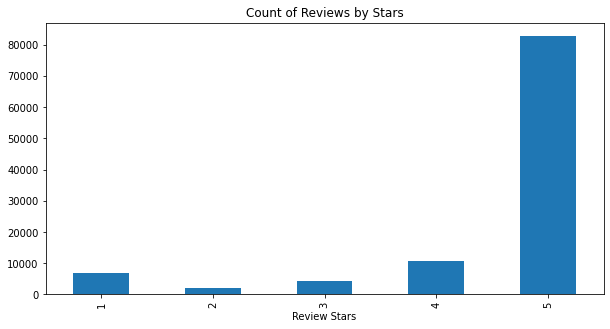

In [17]:
ax = dataset['rating'].value_counts().sort_index()\
                .plot(kind='bar', 
                      title='Count of Reviews by Stars', 
                      figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [18]:
from wordcloud import WordCloud

In [23]:
clean_data_negative = dataset[(dataset['sentiment']==0)]
clean_data_positive = dataset[(dataset['sentiment']==1)]

#convert to list
negative_list = clean_data_negative['reviewContent'].tolist()
positive_list = clean_data_positive['reviewContent'].tolist()

filtered_negative = ("").join(str(negative_list)) #convert the list into a string of spam
filtered_negative = filtered_negative.lower().replace(r'[^\w\s]+', '')

filtered_positive = ("").join(str(positive_list)) #convert the list into a string of ham
filtered_positive = filtered_positive.lower().replace(r'[^\w\s]+', '')

In [26]:
filtered_positive

'[\'bagus  mantap dah sesui pesanan\', \'bagus, sesuai foto\', \'okkkkk mantaaaaaaapppp ... goood\', \'bagus sesuai\', \'pesan rabu sore,minggu sore sampe,,barang sesuai specs mantab,tks lazada\', \'apakah tv. tsb. suda ada anti gores..\', \'kualitas ok\', \'ok barang sampai dengan baik.. smoga terus di pertahankan...\', \'kalau mau cicilan gmna cra nya??\', \'barang sudah sampai dan bagus thanks lazada\', \'pengiriman cepat sipplahhh.......\', \'sampe sekarang masih ok ne laptop...\', \'pengiriman cepat..  packaging good..  barang oke. thnks seller thnks lazada\', \'barang diterima dengan selamat.. produk sesuai dengan deskripsi.. barang nyape 3 hari ke pekanbaru,riau.. terimakasih lazada dan kotakom pucang, laptopnya mantap..\', \'senang belanja disini,pelayanan oke,barang sesuai ekspektasi..order senin hari selasa malam udah nyampe + di settingin sxan sama kurirnya...pokoknya top deh..thanks lazada\', \'belum test barangnya\', \'barang ok, kualitas bagus dengan harga yg cukup miring

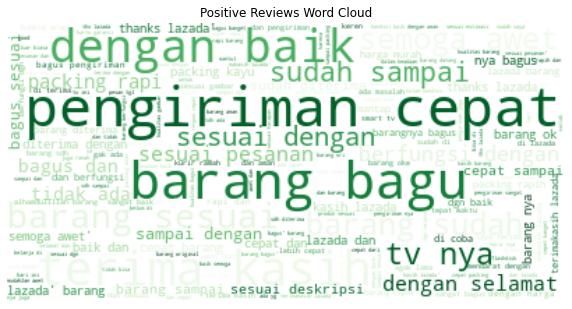

In [20]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="Greens").generate(filtered_positive)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Positive Reviews Word Cloud")
plt.show()

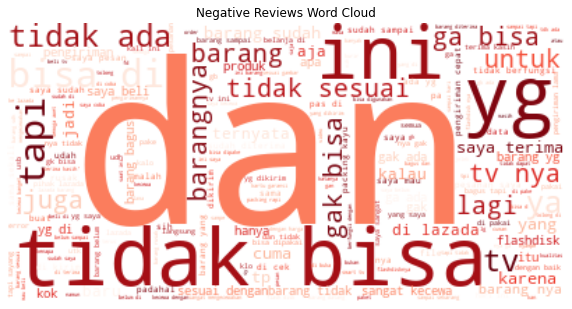

In [21]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="Reds").generate(filtered_negative)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Negative Reviews Word Cloud")
plt.show()

## Balancing data

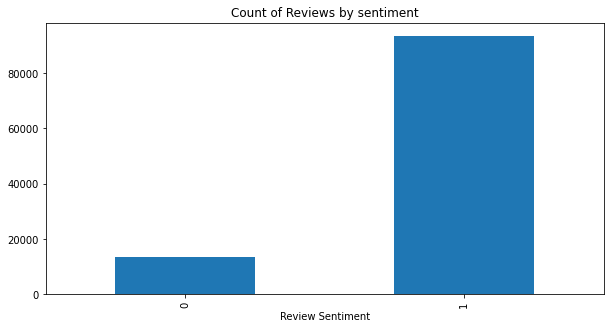

In [22]:
ax = dataset['sentiment'].value_counts().sort_index()\
                .plot(kind='bar', 
                      title='Count of Reviews by sentiment', 
                      figsize=(10, 5))
ax.set_xlabel('Review Sentiment')
plt.show()

In [23]:
features = dataset[['reviewContent', 'Review_len','punct']]
labels = dataset[['sentiment']]

In [24]:
from imblearn.under_sampling import RandomUnderSampler

In [25]:
rus = RandomUnderSampler(random_state=42)
features_resampled, labels_resampled = rus.fit_resample(features, labels)

# Create a new balanced DataFrame
dataset_resampled = pd.DataFrame(features_resampled, columns=features.columns)
dataset_resampled['sentiment'] = labels_resampled
dataset_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27014 entries, 0 to 27013
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewContent  27014 non-null  object 
 1   Review_len     27014 non-null  int64  
 2   punct          27014 non-null  float64
 3   sentiment      27014 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 844.3+ KB


[Text(0, 0, '13507'), Text(0, 0, '13507')]

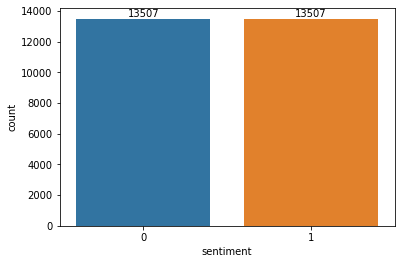

In [26]:
ax = sns.countplot(data = dataset_resampled, x = 'sentiment', label = dataset_resampled['sentiment'].unique())
ax.bar_label(ax.containers[0])

In [27]:
dataset_resampled['sentiment'].unique()

array([0, 1], dtype=int64)

In [28]:
dataset_resampled.head()

reviewContent  Review_len  punct  \
0                                               bima           4    0.0   
1                baru 10 bulan layarnya dah bergaris          30    0.0   
2         Mau tanya ini cicilnya pake apa ya,cc bkn?          35    5.7   
3  Pengirim barang tidak sesuai janji. Katanya ex...         109    3.7   
4  Bagaimana tv LED saya merek Sharp 24 hitam LC ...         211    2.8   

   sentiment  
0          0  
1          0  
2          0  
3          0  
4          0

In [29]:
dataset_resampled_random = dataset_resampled.sample(n=1000)

In [30]:
dataset_resampled_random.head()

reviewContent  Review_len  punct  \
20968                                             mantap           6    0.0   
25894                                       Produk good😊          11    0.0   
20176                                                 ok           2    0.0   
4322   sangat kecewa krn keterangannya fleshdisk tosh...         154    7.1   
19808                                       mntap tv nya          10    0.0   

       sentiment  
20968          1  
25894          1  
20176          1  
4322           0  
19808          1

[Text(0, 0, '501'), Text(0, 0, '499')]

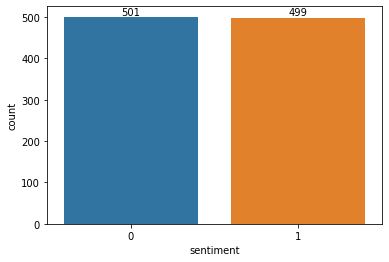

In [31]:
ax = sns.countplot(data = dataset_resampled_random, x = 'sentiment', label = dataset_resampled_random['sentiment'].unique())
ax.bar_label(ax.containers[0])

In [32]:
from tqdm import tqdm
import time

# Function to apply with progress bar
def process_item(item):
    # Simulate some processing time
    time.sleep(0.1)

# Generate a list of items to process
items = range(100)

# Apply the function with progress bar
for item in tqdm(items):
    process_item(item)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.18it/s]


## Text Processing

In [33]:
dataset_resampled_random['reviewContent'].astype(str)

20968                                               mantap
25894                                         Produk good😊
20176                                                   ok
4322     sangat kecewa krn keterangannya fleshdisk tosh...
19808                                         mntap tv nya
                               ...                        
17770    setelah di format, isinya kurang dari 64 GB, t...
4229     barang taik.. gak suppoort data dipindah malah...
6289     Dear lazada, Apakah produk ini bergaransi resm...
6716     packing rapi dgn bubble wrap, dus dan sterofom...
16187                     mantap ... joss ... jaminan mutu
Name: reviewContent, Length: 1000, dtype: object

In [34]:
dataset_resampled_textpreprocessing = pd.DataFrame(dataset_resampled['reviewContent'])

In [35]:
dataset_resampled_random['text_only'] = dataset_resampled_random['reviewContent'].apply(lambda x:fc.remove_punct(x))   #df['text_only'] = df['Tweet'].str.replace(r'[^\w\s]|_', '', regex=True) #WORK

In [36]:
from tqdm import tqdm
import pandas as pd

In [37]:
dataset_resampled_random['lowercase'] = dataset_resampled_random['text_only'].apply(lambda x:fc.case_folding(x))
dataset_resampled_random.head()

reviewContent  Review_len  punct  \
20968                                             mantap           6    0.0   
25894                                       Produk good😊          11    0.0   
20176                                                 ok           2    0.0   
4322   sangat kecewa krn keterangannya fleshdisk tosh...         154    7.1   
19808                                       mntap tv nya          10    0.0   

       sentiment                                          text_only  \
20968          1                                             mantap   
25894          1                                       Produk good    
20176          1                                                 ok   
4322           0  sangat kecewa krn keterangannya fleshdisk tosh...   
19808          1                                       mntap tv nya   

                                               lowercase  
20968                                             mantap  
25894                                       produk good   
20176                                                 ok  
4322   sangat kecewa krn keterangannya fleshdisk tosh...  
19808                                       mntap tv nya

In [38]:
dataset_resampled_random.head()

reviewContent  Review_len  punct  \
20968                                             mantap           6    0.0   
25894                                       Produk good😊          11    0.0   
20176                                                 ok           2    0.0   
4322   sangat kecewa krn keterangannya fleshdisk tosh...         154    7.1   
19808                                       mntap tv nya          10    0.0   

       sentiment                                          text_only  \
20968          1                                             mantap   
25894          1                                       Produk good    
20176          1                                                 ok   
4322           0  sangat kecewa krn keterangannya fleshdisk tosh...   
19808          1                                       mntap tv nya   

                                               lowercase  
20968                                             mantap  
25894                                       produk good   
20176                                                 ok  
4322   sangat kecewa krn keterangannya fleshdisk tosh...  
19808                                       mntap tv nya

In [39]:
dataset_resampled_random['sentiment'].unique()

array([1, 0], dtype=int64)

In [40]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

dataset_resampled_random['stemming'] = tqdm(dataset_resampled_random['lowercase'].apply(fc.stemming), desc="Stemming Progress") 

Stemming Progress: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:00<?, ?it/s]


In [41]:
dataset_resampled_random['tokenizing'] = dataset_resampled_random['stemming'].apply(lambda x: fc.tokenization(str(x)))
dataset_resampled_random.head()

#df['tokenizing'] = df['lowercase'].apply(lambda x: fc.tokenization(x.lower()))

reviewContent  Review_len  punct  \
20968                                             mantap           6    0.0   
25894                                       Produk good😊          11    0.0   
20176                                                 ok           2    0.0   
4322   sangat kecewa krn keterangannya fleshdisk tosh...         154    7.1   
19808                                       mntap tv nya          10    0.0   

       sentiment                                          text_only  \
20968          1                                             mantap   
25894          1                                       Produk good    
20176          1                                                 ok   
4322           0  sangat kecewa krn keterangannya fleshdisk tosh...   
19808          1                                       mntap tv nya   

                                               lowercase  \
20968                                             mantap   
25894                                       produk good    
20176                                                 ok   
4322   sangat kecewa krn keterangannya fleshdisk tosh...   
19808                                       mntap tv nya   

                                                stemming  \
20968                                             mantap   
25894                                        produk good   
20176                                                 ok   
4322   sangat kecewa krn terang fleshdisk toshiba gb ...   
19808                                       mntap tv nya   

                                              tokenizing  
20968                                           [mantap]  
25894                                     [produk, good]  
20176                                               [ok]  
4322   [sangat, kecewa, krn, terang, fleshdisk, toshi...  
19808                                   [mntap, tv, nya]

### Load Kamus

In [42]:
df_uploaded_kamusalay = pd.read_csv(config["kamus_path"], encoding='latin-1')

In [43]:
df_uploaded_kamusalay.head(5)

anakjakartaasikasik anak jakarta asyik asyik
0        pakcikdahtua        pak cik sudah tua
1      pakcikmudalagi        pak cik muda lagi
2         t3tapjokowi             tetap jokowi
3                  3x                tiga kali
4              aamiin                     amin

In [44]:
kamusalay_dict = dict(df_uploaded_kamusalay.values)

In [157]:
pickle_dump(kamusalay_dict, config["kamusalay_dict"])

In [45]:
try: 
    dataset_resampled_random['normalization'] = dataset_resampled_random['tokenizing'].apply(lambda x: fc.normalisasi(x))    
except:
    dataset_resampled_random['normalization'] = dataset_resampled_random['tokenizing']

In [46]:
dataset_resampled_random['normalization'].head()

20968                                             [mantap]
25894                                       [produk, good]
20176                                                 [ok]
4322     [sangat, kecewa, krn, terang, fleshdisk, toshi...
19808                                     [mntap, tv, nya]
Name: normalization, dtype: object

In [47]:
dataset_resampled_random['after_stopword'] = dataset_resampled_random['normalization'].apply(lambda x: fc.remove_stopwords(x))
dataset_resampled_random.head()

reviewContent  Review_len  punct  \
20968                                             mantap           6    0.0   
25894                                       Produk good😊          11    0.0   
20176                                                 ok           2    0.0   
4322   sangat kecewa krn keterangannya fleshdisk tosh...         154    7.1   
19808                                       mntap tv nya          10    0.0   

       sentiment                                          text_only  \
20968          1                                             mantap   
25894          1                                       Produk good    
20176          1                                                 ok   
4322           0  sangat kecewa krn keterangannya fleshdisk tosh...   
19808          1                                       mntap tv nya   

                                               lowercase  \
20968                                             mantap   
25894                                       produk good    
20176                                                 ok   
4322   sangat kecewa krn keterangannya fleshdisk tosh...   
19808                                       mntap tv nya   

                                                stemming  \
20968                                             mantap   
25894                                        produk good   
20176                                                 ok   
4322   sangat kecewa krn terang fleshdisk toshiba gb ...   
19808                                       mntap tv nya   

                                              tokenizing  \
20968                                           [mantap]   
25894                                     [produk, good]   
20176                                               [ok]   
4322   [sangat, kecewa, krn, terang, fleshdisk, toshi...   
19808                                   [mntap, tv, nya]   

                                           normalization  \
20968                                           [mantap]   
25894                                     [produk, good]   
20176                                               [ok]   
4322   [sangat, kecewa, krn, terang, fleshdisk, toshi...   
19808                                   [mntap, tv, nya]   

                                          after_stopword  
20968                                           [mantap]  
25894                                     [produk, good]  
20176                                               [ok]  
4322   [kecewa, krn, terang, fleshdisk, toshiba, gb, ...  
19808                                   [mntap, tv, nya]

In [48]:
dataset_resampled_random['detokenizing']=dataset_resampled_random['after_stopword'].apply(lambda x: fc.detokenize_text(x))

In [49]:
dataset_resampled_random['cleaned_data'] = dataset_resampled_random['detokenizing'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ').str.replace('xf','')

C:\Users\Prayogi Adista\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
#dataset_resampled_random = dataset_resampled_random.iloc[0:100]

In [50]:
dataset_resampled_random = dataset_resampled_random.reset_index()
dataset_resampled_random.head()

index                                      reviewContent  Review_len  \
0  20968                                             mantap           6   
1  25894                                       Produk good😊          11   
2  20176                                                 ok           2   
3   4322  sangat kecewa krn keterangannya fleshdisk tosh...         154   
4  19808                                       mntap tv nya          10   

   punct  sentiment                                          text_only  \
0    0.0          1                                             mantap   
1    0.0          1                                       Produk good    
2    0.0          1                                                 ok   
3    7.1          0  sangat kecewa krn keterangannya fleshdisk tosh...   
4    0.0          1                                       mntap tv nya   

                                           lowercase  \
0                                             mantap   
1                                       produk good    
2                                                 ok   
3  sangat kecewa krn keterangannya fleshdisk tosh...   
4                                       mntap tv nya   

                                            stemming  \
0                                             mantap   
1                                        produk good   
2                                                 ok   
3  sangat kecewa krn terang fleshdisk toshiba gb ...   
4                                       mntap tv nya   

                                          tokenizing  \
0                                           [mantap]   
1                                     [produk, good]   
2                                               [ok]   
3  [sangat, kecewa, krn, terang, fleshdisk, toshi...   
4                                   [mntap, tv, nya]   

                                       normalization  \
0                                           [mantap]   
1                                     [produk, good]   
2                                               [ok]   
3  [sangat, kecewa, krn, terang, fleshdisk, toshi...   
4                                   [mntap, tv, nya]   

                                      after_stopword  \
0                                           [mantap]   
1                                     [produk, good]   
2                                               [ok]   
3  [kecewa, krn, terang, fleshdisk, toshiba, gb, ...   
4                                   [mntap, tv, nya]   

                                        detokenizing  \
0                                             mantap   
1                                        produk good   
2                                                 ok   
3  kecewa krn terang fleshdisk toshiba gb free fl...   
4                                       mntap tv nya   

                                        cleaned_data  
0                                             mantap  
1                                        produk good  
2                                                 ok  
3  kecewa krn terang fleshdisk toshiba gb free fl...  
4                                       mntap tv nya

In [51]:
dataset_resampled_random_model = pd.DataFrame(dataset_resampled_random[['cleaned_data','Review_len','punct','sentiment']])

In [107]:
dataset_resampled_random_model.rename(columns={'Review_len': 'review_len'}, inplace=True)

In [108]:
dataset_resampled_random_model['sentiment'].unique()

array([1, 0], dtype=int64)

In [109]:
dataset_resampled_random_model.head()

cleaned_data  review_len  punct  \
0                                             mantap           6    0.0   
1                                        produk good          11    0.0   
2                                                 ok           2    0.0   
3  kecewa krn terang fleshdisk toshiba gb free fl...         154    7.1   
4                                       mntap tv nya          10    0.0   

   sentiment  
0          1  
1          1  
2          1  
3          0  
4          1

In [110]:
dataset_resampled_random_model.shape

(1000, 4)

## Training-Test Data Split

In [111]:
X = dataset_resampled_random_model[config["predictors"]]
y = dataset_resampled_random_model[config["label"]]

print(X.shape)
print(y.shape)

(1000, 3)
(1000,)


In [112]:
X

cleaned_data  review_len  punct
0                                               mantap           6    0.0
1                                          produk good          11    0.0
2                                                   ok           2    0.0
3    kecewa krn terang fleshdisk toshiba gb free fl...         154    7.1
4                                         mntap tv nya          10    0.0
..                                                 ...         ...    ...
995  format isi gb tp ya sesuai harga nyari murah b...          89    6.7
996  barang taik gak suppoort data pindah ilang kom...         110    7.3
997  dear lazada produk garansi resmi dpt langsung ...         110    3.6
998  packing rapi dgn bubble wrap dus sterofom kond...         137    5.1
999                             mantap joss jamin mutu          27   22.2

[1000 rows x 3 columns]

In [113]:
y.unique()

array([1, 0], dtype=int64)

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(700, 3)
(300, 3)
(700,)
(300,)


## Dump Trainset

In [144]:
def pickle_dump(data, file_path: str) -> None:
    # Dump data into file
    joblib.dump(data, file_path)

In [145]:
pickle_dump(dataset_resampled_random_model, config["dataset_cleaned_path"])

In [159]:
pickle_dump(X_train, config["train_set_path"][0])
pickle_dump(y_train, config["train_set_path"][1])

pickle_dump(X_test, config["test_set_path"][0])
pickle_dump(y_test, config["test_set_path"][1])

### Vectorizing Data Text

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df = 0.5, min_df = 2) # ignore terms that occur in more than 50% documents and the ones that occur in less than 2
tfidf_train = tfidf.fit_transform(X_train['cleaned_data'])
tfidf_test = tfidf.transform(X_test['cleaned_data'])

X_train_vect = pd.concat([X_train[['review_len', 'punct']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['review_len', 'punct']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()  

#X_train_vect = pd.DataFrame(tfidf_train.toarray())

#X_test_vect = pd.DataFrame(tfidf_test.toarray())
    
#X_train_vect

review_len  punct         0    1    2         3    4    5    6    7  ...  \
0          72   20.8  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
1          10    0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
2         102    1.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
3          87    4.6  0.368792  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
4         137    7.3  0.000000  0.0  0.0  0.211916  0.0  0.0  0.0  0.0  ...   

   703  704  705  706  707  708  709  710       711  712  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.178549  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.281283  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  

[5 rows x 715 columns]

#### Dump Data Training & Text (Vector)

In [ ]:
pickle_dump(X_train_vect, config["vect_set_path"][0])
pickle_dump(X_test_vect, config["vect_set_path"][1])

In [ ]:
pickle_dump(X_test_vect, config["vect_set_path"][1])

In [ ]:
X_train_vect.head()

review_len  punct         0    1    2         3    4    5    6    7  ...  \
0          72   20.8  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
1          10    0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
2         102    1.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
3          87    4.6  0.368792  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...   
4         137    7.3  0.000000  0.0  0.0  0.211916  0.0  0.0  0.0  0.0  ...   

   703  704  705  706  707  708  709  710       711  712  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.178549  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.281283  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  

[5 rows x 715 columns]

In [ ]:
print(X_train_vect1.shape)
print(X_test_vect1.shape)
print(y_train.shape)
print(y_test.shape)

(700, 715)
(300, 715)
(700,)
(300,)


In [ ]:
print(X_train_vect1.shape)
print(X_test_vect1.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
X_train_vect1 = X_train_vect.reshape(X_train_vect.shape[0], X_train_vect.shape[1])
X_test_vect1 = X_test_vect.reshape(X_test_vect.shape[0], X_test_vect.shape[1])


In [ ]:
print(X_train_vect.shape)

(700, 715, 1)
